In [11]:
# %%
import numpy as np
from numpy import sin, cos, pi
import gym
import seagul.envs

from seagul.integration import rk4,euler
from control import lqr, ctrb
from torch.multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib

#matplotlib.use('Qt5Agg')

import time

global_start = time.time()

# %%
m1 = 1
m2 = 1
l1 = 1
l2 = 2
lc1 = .5
lc2 = 1
I1 = .083
I2 = .33
g = 9.8

#
# m1 = 1
# m2 = 1
# l1 = 1
# l2 = 1
# lc1 = .5
# lc2 = .5
# I1 = .2
# I2 = 1.0
# g = 9.8


dt = .01
max_torque = 25
integrator = euler

Q = np.identity(4)
Q[0, 0] = 1
Q[1, 1] = 1
Q[2, 2] = 1
Q[3, 3] = 1
#
# Q = np.array([[1000, -500, 0,0],[-500, 1000, 0, 0],[0, 0, 1000, -500],[0,0,-500,1000]])
R = np.identity(2) * .01

eval_max_t = 10


th1 = pi / 2
th2 = 0
th1d = 0
th2d = 0

TAU = np.array([[0], [1]])

m11 = m1 * lc1 ** 2 + m2 * (l1 ** 2 + lc2 ** 2 + 2 * l1 * lc2 * cos(th2)) + I1 + I2
m22 = m2 * lc2 ** 2 + I2
m12 = m2 * (lc2 ** 2 + l1 * lc2 * cos(th2)) + I2
M = np.array([[m11, m12], [m12, m22]])

h1 = -m2 * l1 * lc2 * sin(th2) * th2d ** 2 - 2 * m2 * l1 * lc2 * sin(th2) * th2d * th1d
h2 = m2 * l1 * lc2 * sin(th2) * th1d ** 2
H = np.array([[h1], [h2]])

phi1 = (m1 * lc1 + m2 * l1) * g * cos(th1) + m2 * lc2 * g * cos(th1 + th2)
phi2 = m2 * lc2 * g * cos(th1 + th2)
PHI = np.array([[phi1], [phi2]])

Bl = np.linalg.inv(M) @ TAU
Blin = np.array([[0, 0], [0, 0], [0, Bl[0].item()], [0, Bl[1].item()]])

DPHI = np.array([[-g * (m1 * lc1 + m2 * l1 + m2 * lc2), -m2 * lc2 * g], [-m2 * lc2 * g, -m2 * lc2 * g]])
Al = -np.linalg.inv(M) @ DPHI
Alin = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [Al[0, 0], Al[0, 1], 0, 0], [Al[1, 0], Al[1, 1], 0, 0]])

Ctr = ctrb(Alin, Blin)
assert np.linalg.matrix_rank(Ctr) == 4

K, S, E = lqr(Alin, Blin, Q, R)
k = np.array(K[1, :])
print(k)


def control(q):
    gs = np.array([pi / 2, 0, 0, 0])
    return -k.dot(q - gs)


def reward_fn(s, a):
    reward = np.sin(s[0]) + 2 * np.sin(s[0] + s[1])
    done = reward < 2
    return reward, done


def do_rollout(args):
    x, trial_num = args
    th1, th2, dth1, dth2 = x
    np.random.seed(trial_num)
    local_reward_hist = np.ones((env.num_steps, 1)) * -1
    obs = env.reset(init_vec=[th1, th2, dth1, dth2])

    for i in range(env.num_steps):
        actions = np.clip(np.asarray(control(obs)), -max_torque, max_torque)
        obs, reward, done, _ = env.step(actions)
        local_reward_hist[i, :] = np.copy(reward)
        if done:
            break

    return local_reward_hist, i

[[-787.27034288 -321.29901324 -342.50908801 -158.94341213]]


  0%|          | 0/50 [00:00<?, ?it/s]

54.720113039016724


100%|██████████| 50/50 [01:59<00:00,  2.39s/it]


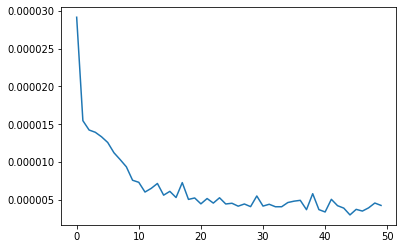

In [12]:
# %%b
start = time.time()
config = {"init_state": [0, 0, 0, 0],
          "max_torque": max_torque,
          "init_state_weights": [0, 0, 0, 0],
          "max_t" : 2.5,
          "dt": dt,
          "m2": m2,
          "m1": m1,
          "l1": l1,
          "lc1": lc1,
          "lc2": lc2,
          "i1": I1,
          "i2": I2,
          "integrator" : integrator,
          "reward_fn": reward_fn,
          "act_hold": 1
          }
env = gym.make('su_acrobot-v0', **config)

num_trials = 200000
reward_hist = np.zeros((num_trials, env.num_steps, 1))

X = np.zeros((num_trials, 4), dtype=np.float32)
Y = np.zeros((num_trials, 1), dtype=np.float32)

th1_min = pi / 2 - .5
th1_max = pi / 2 + .5
th2_min = -1.5
th2_max = 1.5
th1dot_min = -5
th1dot_max = 5
th2dot_min = -10
th2dot_max = 10

samples = np.random.random_sample((int(num_trials/2), 4))
samples *= np.array([th1_min - th1_max, th2_min - th2_max, th1dot_min - th1dot_max, th2dot_min - th2dot_max])
samples += np.array([th1_max, th2_max, th1dot_max, th2dot_max])

total_steps = 0
pool = Pool()  # defaults to number of available CPU's
for i, res in enumerate(pool.imap(do_rollout, zip(samples, range(int(num_trials/2))))):
    rews, steps = res
    reward_hist[i, :, :] = rews
    total_steps += steps
    X[i, :] = samples[i, :]
    Y[i] = sum(rews) > env.num_steps*3 - 5


th1_min = 0
th1_max = 2*pi
th2_min = -pi
th2_max = pi
th1dot_min = -10
th1dot_max = 10
th2dot_min = -30
th2dot_max = 30

samples = np.random.random_sample((int(num_trials/2), 4))
samples *= np.array([th1_min - th1_max, th2_min - th2_max, th1dot_min - th1dot_max, th2dot_min - th2dot_max])
samples += np.array([th1_max, th2_max, th1dot_max, th2dot_max])
total_steps = 0


for i, res in enumerate(pool.imap(do_rollout, zip(samples, range(int(num_trials/2), int(num_trials))))):
    rews, steps = res
    reward_hist[i, :, :] = rews
    total_steps += steps
    X[i+int(num_trials/2), :] = samples[i, :]
    Y[i+int(num_trials/2)] = sum(rews) > env.num_steps*3 - 5


print(time.time() - start)

# %%
from seagul.nn import MLP, fit_model
import torch

net = MLP(4, 1, 2, 32)  # output_activation=torch.nn.Softmax)

w = 1e-2
class_weight = torch.tensor(Y.shape[0]/sum(Y)*w, dtype=torch.float32)

loss_hist = fit_model(net, X, Y, 50, batch_size=2048, loss_fn=torch.nn.BCEWithLogitsLoss(pos_weight=class_weight))
#loss_hist = fit_model(net, X, Y, 50, batch_size=2048, loss_fn=torch.nn.BCEWithLogitsLoss())

# loss_hist = fit_model(net, X, Y, 100, batch_size=2048)
# loss_hist = fit_model(net, X, Y0, 5, batch_size=2048, loss_fn=torch.nn.BCEWithLogitsLoss(pos_weight=class_weight))

plt.close()
plt.plot(loss_hist)
plt.show()

# %%

2.310786008834839


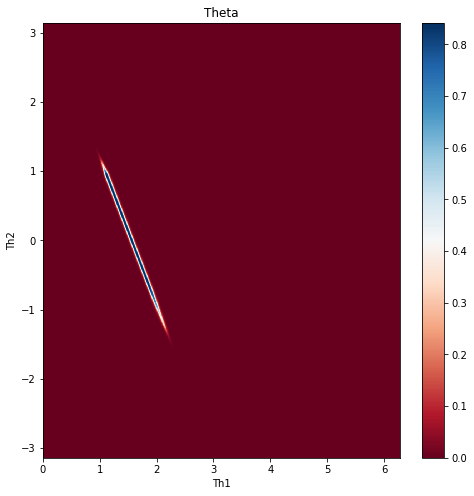

2.2837255001068115


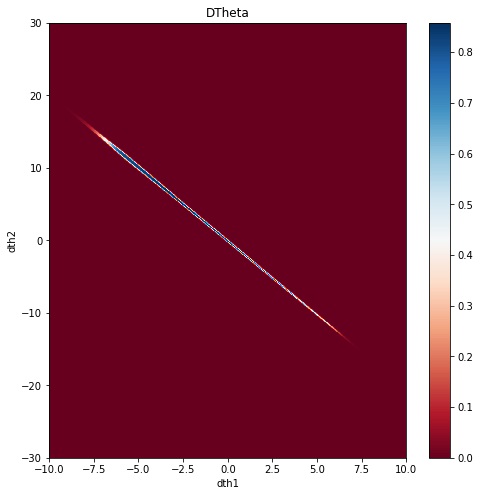

In [3]:
n_thdot = 1
n_th = 1000

th1_vals = np.linspace(0, 2*pi, n_th)
th2_vals = np.linspace(-pi, pi, n_th)

th1dot_vals = np.linspace(-10, 10, n_th)
th2dot_vals = np.linspace(-30, 30, n_th)

sig = torch.nn.Sigmoid()

coords = np.zeros((n_th, n_th, 4), dtype=np.float32)

from itertools import product

start = time.time()
for i, j in product(range(n_th), range(n_th)):
    coords[j, i, :] = np.array([th1_vals[i], th2_vals[j], 0, 0])

preds = sig(net(coords.reshape(-1, 4)).reshape(n_th, n_th).detach())

end = time.time()

print(end - start)

fig, ax = plt.subplots(n_thdot, n_thdot, figsize=(8, 8))
# generate 2 2d grids for the x & y bounds
x, y = np.meshgrid(th1_vals, th2_vals)
z = preds

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = 0, np.abs(z).max()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Theta')
ax.set_xlabel('Th1')
ax.set_ylabel('Th2')

# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)
plt.show()

coords = np.zeros((n_th, n_th, 4), dtype=np.float32)

start = time.time()
for i, j in product(range(n_th), range(n_th)):
    coords[j, i, :] = np.array([pi/2, 0, th1dot_vals[i], th2dot_vals[j]])

preds = sig(net(coords.reshape(-1, 4)).reshape(n_th, n_th).detach())
end = time.time()

print(end - start)

fig, ax = plt.subplots(n_thdot, n_thdot, figsize=(8, 8))
# generate 2 2d grids for the x & y bounds
x, y = np.meshgrid(th1dot_vals, th2dot_vals)
z = preds

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = 0, np.abs(z).max()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('DTheta')
ax.set_xlabel('dth1')
ax.set_ylabel('dth2')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)
plt.show()

In [14]:
# %%

torch.set_default_dtype(torch.float32)


def reward_fn(s, a):
    reward = np.sin(s[0]) + 2 * np.sin(s[0] + s[1])
    return reward, False


def do_rollout(trial_num):
    np.random.seed()
    act_hold = 20
    hold_count = 0

    obs = env.reset()
    local_lqr = False

    actions = np.random.randn(1) * 3

    local_state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
    local_reward_hist = np.zeros((env.num_steps, 1))
    local_gate_hist = np.zeros((env.num_steps, 1))
    local_action_hist = np.zeros((env.num_steps, 1))

    for i in range(env.num_steps):
        obs = np.array(obs, dtype=np.float32)
        if sig(net(obs)) > .9:
            actions = np.clip(np.asarray(control(obs)), -max_torque, max_torque)
            local_lqr = True
            local_gate_hist[i] = 1
        else:
            local_gate_hist[i] = 0
            if hold_count == act_hold:
                actions = np.random.randn(1) * 3
                hold_count = 0

        hold_count += 1
        obs, reward, done, _ = env.step(actions)
        local_action_hist[i, :] = np.copy(actions)
        local_state_hist[i, :] = np.copy(obs)
        local_reward_hist[i, :] = np.copy(reward)

    return local_action_hist, local_state_hist, local_reward_hist, local_gate_hist, local_lqr


config = {"init_state": [-pi / 2, 0, 0, 0],
          "max_torque": max_torque,
          "init_state_weights": [1, 1, 0, 0],
          "dt": dt,
          "m2": m2,
          "m1": m1,
          "l1": l1,
          "lc1": lc1,
          "lc2": lc2,
          "i1": I1,
          "i2": I2,
          "integrator" : integrator,
          "reward_fn": reward_fn,
          "act_hold": 1,
          "max_t" : 10
          }

env = gym.make('su_acrobot-v0', **config)

num_trials = 1000
action_hist = np.zeros((num_trials, env.num_steps, 1))
state_hist = np.zeros((num_trials, env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((num_trials, env.num_steps, 1))
gate_hist = np.zeros((num_trials, env.num_steps, 1))
err_hist = np.zeros((num_trials, 1))

lqr_list = []
success_list = []

act_hold = 20
hold_count = 0
obs = env.reset()

start = time.time()

pool = Pool() # defaults to number of available CPU's
for i, res in enumerate(pool.imap(do_rollout,range(num_trials))):
    acts, obs, rews, gate, lqr_on = res
    action_hist[i, :, :] = acts
    state_hist[i, :, :] = obs
    reward_hist[i, :, :] = rews
    gate_hist[i, :, :] = gate
    err_hist[i] = (np.sqrt(sum(((state_hist[i, -1, :] - np.array([pi / 2, 0, 0, 0])) ** 2))))
    if lqr_on:
        lqr_list.append(i)
        #print(err_hist[i])
        #print(reward_hist[i,-1])
        if err_hist[i] < 2:
            success_list.append(i)


# for i in (range(num_trials)):
#     res = do_rollout(i)
#     acts, obs, rews, gate, lqr_on = res
#     action_hist[i, :, :] = acts
#     state_hist[i, :, :] = obs
#     reward_hist[i, :, :] = rews
#     gate_hist[i, :, :] = gate
#     err_hist[i] = (np.sqrt(sum(((state_hist[i, -1, :] - np.array([pi / 2, 0, 0, 0])) ** 2))))
#     if lqr_on:
#         lqr_list.append(i)
#         #print(err_hist[i])
#         #print(reward_hist[i,-1])
#         if err_hist[i] < 2:
#             success_list.append(i)


print(len(lqr_list))
print(len(success_list))

print((time.time() - global_start) / 60)

1
1
5.55236968199412
